In [1]:
import pandas as pd
from Historic_Crypto import HistoricalData
import tensorflow as tf
from tensorflow.keras import layers
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from matplotlib import style, pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
FOLDER_NAME = 'bitcoin_5_mins'
tf.random.set_seed(42)
WINDOW = 30
HALVING_DATES = [datetime.strptime(date, "%d/%m/%Y") for date in ['09/07/2016', '11/05/2020', '02/03/2024']]

In [4]:
def plot_confusion_matrix(y_test, y_preds, title):
    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),                     
                     annot=True,                
                     cmap="Oranges",linewidths=.10, fmt= '.0f',
                     annot_kws={
                    'fontsize': 30,
                    })
    plt.title(title, fontsize=30)
    plt.xlabel("Valor real", fontsize=25)
    plt.ylabel("Valor predicho", fontsize=25)

In [5]:
def plot_null_values_map(df, title="Missing Values"):
    sns.set(font_scale=2)
    colours = ['#F16913', '#7F2704']
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = sns.heatmap(df.isnull(),             
                     cmap=sns.color_palette(colours),
                     annot_kws={
                    'fontsize': 30,
                    })
    plt.title(title, fontsize=30)
    plt.ylabel("Index", fontsize=25)

In [6]:
def get_dataset(name, folder_name=FOLDER_NAME):
    df = pd.read_csv(os.path.join(folder_name, name), parse_dates=['time'])
    return df.set_index('time')

In [7]:
def days_till_halving(row, halving_dates=HALVING_DATES):
    date = row.time
    closest_halving_index = 0
    while halving_dates[closest_halving_index] < date:
        closest_halving_index += 1
    delta = halving_dates[closest_halving_index] - date
    return delta.days

In [8]:
def block_size(row, halving_dates=HALVING_DATES):
    date = row.time
    i = 0
    size = 25
    while date > halving_dates[i]:
        i += 1
        size /= 2
    return size

In [9]:
def get_label_values_from_dataframe(df, window_size=WINDOW):
    res = df.copy()
    y = df.iloc[window_size:]["Increment_up"].to_numpy()
    x = np.array([res.iloc[i: window_size + i].to_numpy() for i in range(len(res) - window_size)])
    return x, y

In [10]:
def shuffle_together(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [11]:
def create_Xt_Yt(X, y, split_size=0.9):
    split = int(len(X) * split_size)
    X_train = X[0:split]
    Y_train = y[0:split]
    X_train, Y_train = shuffle_together(X_train, Y_train)
    X_test = X[split:]
    Y_test = y[split:]
    return X_train, X_test, Y_train, Y_test

In [12]:
def find_gap(df):
    gap_res = []
    gap_res.append(0)
    for i in range(0,len(df)-1):
        gap = abs(df["open"][i+1] - df["close"][i])/ df["close"][i]
        gap_res.append(gap)
    return pd.DataFrame(gap_res)

In [13]:
def find_emad(df, fast, slow):
    params = [fast,slow]
    params = pd.DataFrame(params)
    faster = int(params.min())
    slower = int(params.max())
    alpha_slow = 2 / (slower + 1)
    sma_slow = []
    ema_slow = []
    for i in range(0,len(df)):
        smas = 0 if (i < (slower-1)) else df["close"][i-(slower-1):i+1].mean()
        sma_slow.append(smas)
        if i < (slower-1):
            emas = 0
        elif i == (slower-1):
            emas = df["close"][i-(slower-1):i+1].mean()
        else:
            emas = (alpha_slow * df["close"][i]) + ((1 - alpha_slow)*ema_slow[i-1])
        ema_slow.append(emas)
    alpha_fast = 2 / (faster + 1)
    sma_fast = []
    ema_fast = []
    for i in range(0,len(df)):
        smaf = 0 if (i < (slower-1)) else df["close"][i-(faster-1):i+1].mean()
        sma_fast.append(smaf)
        if i < (slower-1):
            emaf = 0
        elif i == (slower-1):
            emaf = df["close"][i-(faster-1):i+1].mean()
        else:
            emaf = (alpha_fast * df["close"][i]) + ((1 - alpha_fast)*ema_fast[i-1])
        ema_fast.append(emaf)
    emad_res = pd.DataFrame(ema_fast) - pd.DataFrame(ema_slow)
    return emad_res

In [14]:
def find_stoch(df, k, smooth):
    params = [k,smooth]
    params = pd.DataFrame(params)
    smooth_per = int(params.min())
    k_per = int(params.max())
    otstup = (k_per + smooth_per)-1
    max_high = []
    min_low = []
    k_res = []
    for i in range(0,len(df)):
        high = 0 if (i < (k_per-1)) else df["high"][i-(k_per-1):i+1].max()
        low = 0 if (i < (k_per-1)) else df["low"][i-(k_per-1):i+1].min()
        k_pokaz = 0 if (i < (k_per-1)) else (df["close"][i] - low) / (high - low)
        max_high.append(high)
        min_low.append(low)
        k_res.append(k_pokaz)
    stoch_k = pd.DataFrame(k_res)
    stoch_res = []
    for i in range(0,len(df)):
        smooth_k = 0 if (i < (otstup-1)) else stoch_k[i-(smooth_per-1):i+1].mean()
        stoch_res.append(float(smooth_k))
    return pd.DataFrame(stoch_res)

In [15]:
def find_volat(df, period):
    volat_res = []
    for i in range(0,len(df)):
        volat = 0 if (i < (period-1)) else df["close"][i-(period-1):i+1].std()
        volat_res.append(volat)
    return pd.DataFrame(volat_res)

In [16]:
df_list = [get_dataset(f'Bitcoin_{i}.csv') for i in range(1, len(os.listdir(FOLDER_NAME)) + 1)]

In [17]:
minutal = pd.concat(df_list, axis=0)
minutal.sort_index(inplace=True)
minutal

,low,high,open,close,volume
time,,,,,
2015-07-20 21:35:00,277.97,277.99,277.98,277.97,1.501500
2015-07-20 21:40:00,277.98,278.00,277.98,277.99,17.756475
2015-07-20 21:45:00,277.98,278.00,278.00,277.99,13.655500
2015-07-20 21:50:00,277.92,278.00,277.98,277.94,12.433782
2015-07-20 21:55:00,277.95,278.00,278.00,278.00,13.913200
...,...,...,...,...,...
2022-08-24 23:40:00,21371.87,21458.32,21449.15,21386.88,122.407661
2022-08-24 23:45:00,21360.32,21410.75,21385.13,21373.02,195.029581
2022-08-24 23:50:00,21363.65,21385.16,21372.50,21369.15,58.331078


In [18]:
last_minute = minutal.tail(1).index.item()
last_minute = last_minute.strftime('%Y-%m-%d-%H-%M')
last_minute

'2022-08-25-00-00'

In [19]:
last_data = HistoricalData('BTC-USD', 300, start_date=last_minute).retrieve_data()

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2022-08-25T00:00:00
Provisional End: 2022-08-26T01:00:00
Data for chunk 1 of 2 extracted
Provisional Start: 2022-08-26T01:00:00
Provisional End: 2022-08-27T02:00:00
Data for chunk 2 of 2 extracted


In [20]:
minutal = pd.concat([minutal, last_data], axis=0)
minutal

,low,high,open,close,volume
time,,,,,
2015-07-20 21:35:00,277.97,277.99,277.98,277.97,1.501500
2015-07-20 21:40:00,277.98,278.00,277.98,277.99,17.756475
2015-07-20 21:45:00,277.98,278.00,278.00,277.99,13.655500
2015-07-20 21:50:00,277.92,278.00,277.98,277.94,12.433782
2015-07-20 21:55:00,277.95,278.00,278.00,278.00,13.913200
...,...,...,...,...,...
2022-08-26 11:50:00,21159.63,21193.02,21179.42,21190.02,90.866616
2022-08-26 11:55:00,21179.07,21212.23,21190.43,21193.45,102.377813
2022-08-26 12:00:00,21156.26,21214.32,21191.89,21165.74,115.756012


In [21]:
ts_index = pd.date_range(start=minutal.head(1).index.item(),
             end=minutal.tail(1).index.item(),
             freq='5T')

In [22]:
len(minutal)

745355

In [23]:
all_minutes = pd.DataFrame(index=ts_index).rename_axis("time")

In [24]:
all_minutes

""
time
2015-07-20 21:35:00
2015-07-20 21:40:00
2015-07-20 21:45:00
2015-07-20 21:50:00
2015-07-20 21:55:00
...
2022-08-26 11:50:00
2022-08-26 11:55:00
2022-08-26 12:00:00


In [25]:
all_minutes = all_minutes.join(minutal, how="left")
all_minutes

,low,high,open,close,volume
time,,,,,
2015-07-20 21:35:00,277.97,277.99,277.98,277.97,1.501500
2015-07-20 21:40:00,277.98,278.00,277.98,277.99,17.756475
2015-07-20 21:45:00,277.98,278.00,278.00,277.99,13.655500
2015-07-20 21:50:00,277.92,278.00,277.98,277.94,12.433782
2015-07-20 21:55:00,277.95,278.00,278.00,278.00,13.913200
...,...,...,...,...,...
2022-08-26 11:50:00,21159.63,21193.02,21179.42,21190.02,90.866616
2022-08-26 11:55:00,21179.07,21212.23,21190.43,21193.45,102.377813
2022-08-26 12:00:00,21156.26,21214.32,21191.89,21165.74,115.756012


In [26]:
all_minutes.isna().sum()

low       1605
high      1605
open      1605
close     1605
volume    1605
dtype: int64

In [27]:
all_minutes.reset_index(inplace=True)

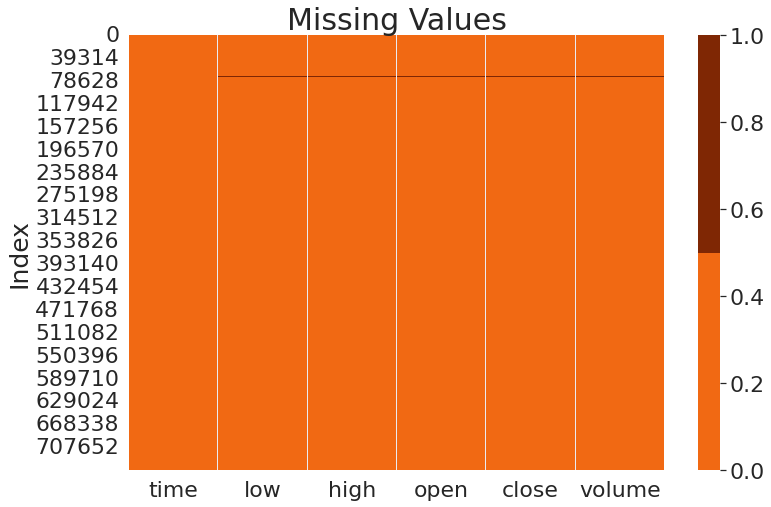

In [28]:
plot_null_values_map(all_minutes)

In [29]:
all_minutes = all_minutes.ffill()

In [30]:
all_minutes.isna().sum()

time      0
low       0
high      0
open      0
close     0
volume    0
dtype: int64

In [31]:
fast_emad = 8
slow_emad = 18
k_stoch = 5
smooth_stoch = 3
period_volat = 6
window_autocorr = 30
lag_autocorr = 4
log_ret = pd.Series(np.log(all_minutes['close']).diff())
all_minutes['Autocorrelacion'] = log_ret.rolling(window=window_autocorr,
min_periods=window_autocorr, center=False).apply(lambda row: row.autocorr(lag=lag_autocorr),raw=False)

In [32]:
all_minutes['Gap'] = find_gap(all_minutes)
all_minutes['Increment_up'] = all_minutes.apply(lambda row: (row.close > row.open), axis=1)
all_minutes['Highest_difference'] = all_minutes.apply(lambda row: (row.high - row.low) / row.low, axis=1)
all_minutes['EMAD'] = find_emad(all_minutes, fast_emad, slow_emad)
all_minutes['Stoch'] = find_stoch(all_minutes, k_stoch, smooth_stoch)
all_minutes['Volatility'] = find_volat(all_minutes, period_volat)
all_minutes['DTH'] = all_minutes.apply(days_till_halving, axis=1)
all_minutes['BS'] = all_minutes.apply(block_size, axis=1)
all_minutes = all_minutes.set_index('time').astype('float32')

<ipython-input-14-bd59ad4dd72c>:13: RuntimeWarning: invalid value encountered in double_scalars
  k_pokaz = 0 if (i < (k_per-1)) else (df["close"][i] - low) / (high - low)


In [33]:
sobrante = [fast_emad, slow_emad, k_stoch, smooth_stoch, period_volat, k_stoch+smooth_stoch-1,
window_autocorr+1, lag_autocorr]
row_del = int(max(sobrante))
all_minutes = all_minutes[row_del-1:]

In [34]:
all_minutes

,low,high,open,close,volume,Autocorrelacion,Gap,Increment_up,Highest_difference,EMAD,Stoch,Volatility,DTH,BS
time,,,,,,,,,,,,,,
2015-07-21 00:05:00,279.579987,279.929993,279.920013,279.739990,34.883709,0.234475,0.000036,0.0,0.001252,0.439899,0.902478,0.424237,353.0,25.00
2015-07-21 00:10:00,279.470001,279.720001,279.720001,279.470001,12.551100,0.229883,0.000071,0.0,0.000895,0.397636,0.722205,0.319479,353.0,25.00
2015-07-21 00:15:00,279.380005,279.929993,279.660004,279.380005,57.694031,0.149512,0.000680,0.0,0.001969,0.348397,0.442133,0.292945,353.0,25.00
2015-07-21 00:20:00,279.480011,279.500000,279.489990,279.500000,16.429899,0.140957,0.000394,1.0,0.000072,0.320016,0.252451,0.258612,353.0,25.00
2015-07-21 00:25:00,279.470001,279.500000,279.480011,279.500000,46.998196,0.152176,0.000072,1.0,0.000107,0.292780,0.172117,0.206268,353.0,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26 11:50:00,21159.630859,21193.019531,21179.419922,21190.019531,90.866615,-0.046512,0.000081,1.0,0.001578,-60.218784,0.751198,15.358827,553.0,6.25
2022-08-26 11:55:00,21179.070312,21212.230469,21190.429688,21193.449219,102.377815,-0.027586,0.000019,1.0,0.001566,-54.318600,0.847739,16.890190,553.0,6.25
2022-08-26 12:00:00,21156.259766,21214.320312,21191.890625,21165.740234,115.756012,-0.043913,0.000074,0.0,0.002744,-52.182949,0.699017,13.184462,553.0,6.25


In [35]:
all_minutes = all_minutes.fillna(0)

In [36]:
min_max_scaler = MinMaxScaler()
all_minutes['Gap'] = min_max_scaler.fit_transform(all_minutes.Gap.values.reshape(-1,1))
all_minutes['Highest_difference'] = min_max_scaler.fit_transform(all_minutes.Highest_difference.values.reshape(-1,1))
all_minutes['volume'] = min_max_scaler.fit_transform(all_minutes.volume.values.reshape(-1,1))
all_minutes['EMAD'] = min_max_scaler.fit_transform(all_minutes.EMAD.values.reshape(-1,1))
all_minutes['Stoch'] = min_max_scaler.fit_transform(all_minutes.Stoch.values.reshape(-1,1))
all_minutes['Volatility'] = min_max_scaler.fit_transform(all_minutes.Volatility.values.reshape(-1,1))
all_minutes['Autocorrelacion'] = min_max_scaler.fit_transform(all_minutes.Autocorrelacion.values.reshape(-1,1))
all_minutes['DTH'] = min_max_scaler.fit_transform(all_minutes.DTH.values.reshape(-1,1))
all_minutes['BS'] = min_max_scaler.fit_transform(all_minutes.BS.values.reshape(-1,1))

In [37]:
delete_cols = ["open", "close", "high", "low"]
for col in delete_cols:
    del all_minutes[col]

In [38]:
all_minutes

,volume,Autocorrelacion,Gap,Increment_up,Highest_difference,EMAD,Stoch,Volatility,DTH,BS
time,,,,,,,,,,
2015-07-21 00:05:00,0.008943,0.644582,0.000516,0.0,0.003903,0.599819,0.902478,0.000180,0.251963,1.0
2015-07-21 00:10:00,0.003218,0.642158,0.001033,0.0,0.002789,0.599806,0.722205,0.000136,0.251963,1.0
2015-07-21 00:15:00,0.014791,0.599730,0.009819,0.0,0.006137,0.599791,0.442133,0.000124,0.251963,1.0
2015-07-21 00:20:00,0.004212,0.595214,0.005686,1.0,0.000223,0.599782,0.252451,0.000110,0.251963,1.0
2015-07-21 00:25:00,0.012049,0.601137,0.001033,1.0,0.000335,0.599774,0.172117,0.000088,0.251963,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-26 11:50:00,0.023296,0.496248,0.001166,1.0,0.004919,0.581197,0.751198,0.006518,0.394718,0.0
2022-08-26 11:55:00,0.026247,0.506239,0.000279,1.0,0.004881,0.583008,0.847739,0.007168,0.394718,0.0
2022-08-26 12:00:00,0.029676,0.497621,0.001063,0.0,0.008555,0.583664,0.699017,0.005595,0.394718,0.0


In [39]:
X, Y = get_label_values_from_dataframe(all_minutes)
n_values = all_minutes.shape[1]

In [44]:
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_values, 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_values, 1))

In [45]:
model= tf.keras.Sequential([
    layers.Conv2D(input_shape = (WINDOW, n_values, 1),filters=16,kernel_size=3,padding='same'),
    layers.LeakyReLU(),
    layers.MaxPooling2D(pool_size=3),
    layers.Conv2D(filters=64,kernel_size=3,padding='same'),
    layers.LeakyReLU(),
    layers.MaxPooling2D(pool_size=2),
    layers.Lambda(lambda x: backend.squeeze(x, 2)),
    layers.LSTM(64,return_sequences=True),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(32),
    layers.LeakyReLU(),
    layers.Dropout(0.7),
    layers.Dense(1),
    layers.Activation('sigmoid')
], name="multivariable-minutal")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=15, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath=model.name, verbose=1, save_best_only=True)
model.compile(optimizer=Adam(), loss='mean_squared_error')

In [46]:
history = model.fit(X_train, Y_train,
    epochs = 100,
    batch_size = 256,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[reduce_lr, checkpointer],
    shuffle=True)

Epoch 1/100
2626/2626 [==============================] - ETA: 0s - loss: 0.2502
Epoch 00001: val_loss improved from inf to 0.24982, saving model to multivariable-minutal
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: multivariable-minutal/assets
2626/2626 [==============================] - 16s 6ms/step - loss: 0.2502 - val_loss: 0.2498 - lr: 0.0010
Epoch 2/100
2616/2626 [============================>.] - ETA: 0s - loss: 0.2489
Epoch 00002: val_loss did not improve from 0.24982
2626/2626 [==============================] - 12s 5ms/step - loss: 0.2489 - val_loss: 0.2499 - lr: 0.0010
Epoch 3/100
2623/2626 [============================>.] - ETA: 0s - loss: 0.2484
Epoch 00003: val_loss improved from 0.24982 to 0.24967, saving model to multivariable-minutal
INFO:tensorflow:Assets written to: multivariable-minutal/assets
2626/2626 [==============================] - 16s 6ms/step - loss: 0.2484 - val_loss: 0.2497 - lr: 0.0010
E

Epoch 32/100
2621/2626 [============================>.] - ETA: 0s - loss: 0.2448
Epoch 00032: val_loss did not improve from 0.24929
2626/2626 [==============================] - 13s 5ms/step - loss: 0.2448 - val_loss: 0.2503 - lr: 1.0000e-04
Epoch 33/100
2621/2626 [============================>.] - ETA: 0s - loss: 0.2448
Epoch 00033: val_loss did not improve from 0.24929
2626/2626 [==============================] - 13s 5ms/step - loss: 0.2448 - val_loss: 0.2504 - lr: 1.0000e-04
Epoch 34/100
2624/2626 [============================>.] - ETA: 0s - loss: 0.2448
Epoch 00034: val_loss did not improve from 0.24929
2626/2626 [==============================] - 13s 5ms/step - loss: 0.2448 - val_loss: 0.2504 - lr: 1.0000e-04
Epoch 35/100
2618/2626 [============================>.] - ETA: 0s - loss: 0.2447
Epoch 00035: val_loss did not improve from 0.24929
2626/2626 [==============================] - 14s 5ms/step - loss: 0.2447 - val_loss: 0.2506 - lr: 1.0000e-04
Epoch 36/100
2625/2626 [============

Epoch 99/100
2625/2626 [============================>.] - ETA: 0s - loss: 0.2443
Epoch 00099: val_loss did not improve from 0.24929
2626/2626 [==============================] - 13s 5ms/step - loss: 0.2443 - val_loss: 0.2507 - lr: 1.0000e-06
Epoch 100/100
2619/2626 [============================>.] - ETA: 0s - loss: 0.2443
Epoch 00100: val_loss did not improve from 0.24929
2626/2626 [==============================] - 14s 5ms/step - loss: 0.2443 - val_loss: 0.2507 - lr: 1.0000e-06


In [53]:
model.summary()

Model: "multivariable-minutal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 10, 16)        160       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 30, 10, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 3, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 3, 64)         9280      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 10, 3, 64)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 1, 64)          0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 5, 64)   

In [54]:
model_best = tf.keras.models.load_model(model.name)

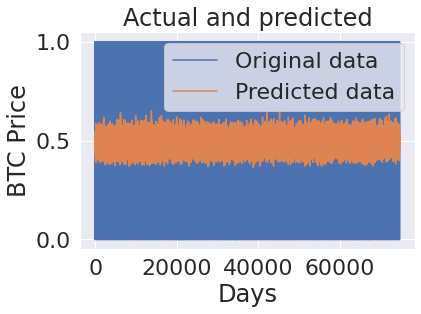

In [55]:
pred = model_best.predict(X_test)
original = Y_test
plt.title('Actual and predicted')
plt.plot(original, label = 'Original data')
plt.plot(pred, label = 'Predicted data')
plt.xlabel('Days')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

In [56]:
matrix = confusion_matrix(Y_test, np.round(pred))
matrix

array([[19480, 17750],
       [17941, 19519]])

In [57]:
print(f"Porcentaje de bajadas acertadas: {matrix[0, 0] / np.sum(matrix[:, 0]) * 100:0.2f}%")
print(f"Porcentaje de subidas acertadas: {matrix[1, 1] / np.sum(matrix[:, 1]) * 100:0.2f}%")
acc = (matrix[0, 0] + matrix[1, 1]) / np.sum(matrix)

Porcentaje de bajadas acertadas: 52.06%
Porcentaje de subidas acertadas: 52.37%


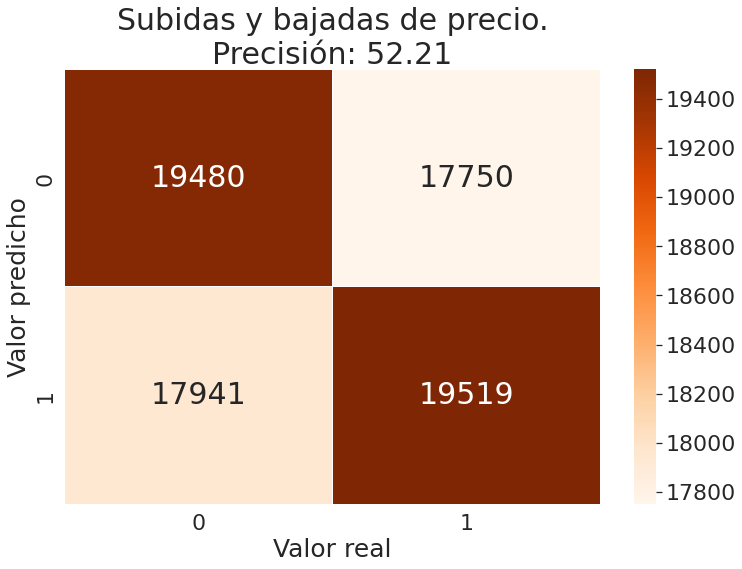

In [58]:
plot_confusion_matrix(Y_test, np.round(pred), 
                      f"Subidas y bajadas de precio.\nPrecisión: {acc*100:.2f}")

In [51]:
all_minutes

,volume,Autocorrelacion,Gap,Increment_up,Highest_difference,EMAD,Stoch,Volatility,DTH,BS
time,,,,,,,,,,
2015-07-21 00:05:00,0.008943,0.644582,0.000516,0.0,0.003903,0.599819,0.902478,0.000180,0.251963,1.0
2015-07-21 00:10:00,0.003218,0.642158,0.001033,0.0,0.002789,0.599806,0.722205,0.000136,0.251963,1.0
2015-07-21 00:15:00,0.014791,0.599730,0.009819,0.0,0.006137,0.599791,0.442133,0.000124,0.251963,1.0
2015-07-21 00:20:00,0.004212,0.595214,0.005686,1.0,0.000223,0.599782,0.252451,0.000110,0.251963,1.0
2015-07-21 00:25:00,0.012049,0.601137,0.001033,1.0,0.000335,0.599774,0.172117,0.000088,0.251963,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-26 11:50:00,0.023296,0.496248,0.001166,1.0,0.004919,0.581197,0.751198,0.006518,0.394718,0.0
2022-08-26 11:55:00,0.026247,0.506239,0.000279,1.0,0.004881,0.583008,0.847739,0.007168,0.394718,0.0
2022-08-26 12:00:00,0.029676,0.497621,0.001063,0.0,0.008555,0.583664,0.699017,0.005595,0.394718,0.0


<AxesSubplot:xlabel='time'>

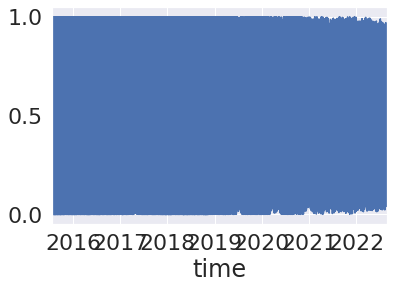

In [52]:
all_minutes["Stoch"].plot()